# Preparation for Data Analysis

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master('local') \
    .appName('Project Spotify') \
    .config("spark.executor.memory", '8g') \
    .config('spark.executor.cores', '4') \
    .config('spark.cores.max', '4') \
    .config("spark.driver.memory",'8g') \
    .getOrCreate()

sc = spark.sparkContext

In [2]:
import os
data_path = '/home/jovyan'
filename = 'spotify_data.csv'
path_to_data = os.path.join(data_path, filename)

In [3]:
df = spark.read.csv(path_to_data, header=True, inferSchema=True)

In [4]:
var_to_keep = [
    'track_id',
    'album_type',
    'release_date',
    'is_explicit',
    'track_popularity',
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms',
    'time_signature',
    'num_follower',
    'song_age'
]

genre = [x for x in df.columns if x not in var_to_keep]

In [5]:
len(var_to_keep)

20

In [6]:
len(genre)

91

In [7]:
var_to_use = [
    'album_type',
    'is_explicit',
    'track_popularity',
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms',
    'time_signature',
    'num_follower',
    'song_age'
]

In [8]:
final_df = df[var_to_use + genre]

In [9]:
label = 'track_popularity'
features = [x for x in final_df.columns if x != label]

In [10]:
# Convert time signature and album type from string to index
from pyspark.ml.feature import StringIndexer
tsIndexer = StringIndexer(inputCol='time_signature',outputCol='tsIndex')
albumTypeIndexer = StringIndexer(inputCol='album_type',outputCol='albumTypeIndex')

final_df = tsIndexer.fit(final_df).transform(final_df)
final_df = albumTypeIndexer.fit(final_df).transform(final_df)

In [11]:
# Ont-hot encoding for key, time signature and album type
from pyspark.ml.feature import OneHotEncoder
keyEncoder=OneHotEncoder(inputCol='key', outputCol='keyVec', dropLast=False)
tsEncoder = OneHotEncoder(inputCol='tsIndex', outputCol='tsVec', dropLast=False)
albumTypeEncoder = OneHotEncoder(inputCol="albumTypeIndex",outputCol="albumTypeVec", dropLast=False)

final_df = keyEncoder.transform(final_df)
final_df = tsEncoder.transform(final_df)
final_df = albumTypeEncoder.transform(final_df)

In [12]:
# Assign pitch class to each key index
pitch_class = {
    0:'C Key',
    1:'C#/Db Key',
    2:'D Key',
    3:'D#/Eb Key',
    4:'E Key',
    5:'F Key',
    6:'F#/Gb Key',
    7:'G Key',
    8:'G#/Ab Key',
    9:'A Key',
    10:'A#/Bb Key',
    11:'B Key'
}

In [13]:
# Map string index back to their own categories
tsDict = final_df.select('time_signature','tsIndex').distinct().sort('tsIndex').toPandas().to_dict('list')
albumTypeDict = final_df.select('album_type','albumTypeIndex').distinct().sort('albumTypeIndex').toPandas().to_dict('list')

In [14]:
# Create variables for each dummy variables
keyDummy = list(pitch_class.values())
tsDummy = ['time_signature_' + str(x) for x in tsDict['time_signature']]
albumTypeDummy = albumTypeDict['album_type']

In [15]:
# Detect the location of each item in the column name list
key_index = features.index('key')
time_signature_index = features.index('time_signature')
album_type_index = features.index('album_type')

In [16]:
# Update the columns list by replacing the categorical variable in reverse order
featureCol = features
featureCol = featureCol[:key_index] + keyDummy + featureCol[key_index+1:]
featureCol = featureCol[:time_signature_index] + tsDummy + featureCol[time_signature_index+1:]
featureCol = featureCol[:album_type_index] + albumTypeDummy + featureCol[album_type_index+1:]

In [17]:
len(featureCol)

125

In [18]:
# Remove all the unnecessary columns
from pyspark.sql.functions import *
final_df = final_df.withColumn('key', col('keyVec')) \
                    .withColumn('time_signature', col('tsVec')) \
                    .withColumn('album_type', col('albumTypeVec')) \
                    .drop('keyVec','tsVec','tsIndex','albumTypeVec','albumTypeIndex')

In [19]:
# Assemble all columns into one feature column
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(inputCols = features, outputCol = "features")
final_df = va.transform(final_df).select('features', col(label).alias('label'))

# Scale all variables in the feature vector
from pyspark.ml.feature import StandardScaler
ss = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
ssModel = ss.fit(final_df)
final_df = ssModel.transform(final_df).select(col('scaledFeatures').alias('features'), 'label')

In [21]:
# Sample 0.01 of the entire data for faster computation
theSeed = 314
sampled_df = final_df.sample(withReplacement=False, fraction=0.01, seed=theSeed)

In [22]:
# Split the sample data into train and test set
train_df, test_df = sampled_df.randomSplit([0.8,0.2], seed=theSeed)

In [23]:
# Cache training set
train_df.cache()

DataFrame[features: vector, label: int]

In [24]:
# Cache test set
test_df.cache()

DataFrame[features: vector, label: int]

In [25]:
# Check the count of training set
train_df.count()

4686

In [26]:
# Check the count of test set
test_df.count()

1174

# Modeling

In [27]:
# Define evaluators for regression metrics
from pyspark.ml.evaluation import RegressionEvaluator
rmse = RegressionEvaluator(predictionCol="prediction", metricName="rmse")
r2 = RegressionEvaluator(predictionCol="prediction", metricName="r2")
mae = RegressionEvaluator(predictionCol="prediction", metricName="mae")

In [28]:
# Define a function that compute relevant metrics
def model_performance(predictions):
    rmse_result = rmse.evaluate(predictions)
    r2_result = r2.evaluate(predictions)
    mae_result = mae.evaluate(predictions)
    return [rmse_result, r2_result, mae_result]

# Cross Validation

In [29]:
# Import models and cross validation packages
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor, GBTRegressor

## Linear Regression

In [30]:
lr = LinearRegression()
lrGrid = ParamGridBuilder() \
            .addGrid(lr.maxIter, [10]) \
            .addGrid(lr.regParam, [0]) \
            .build()
lrCv = CrossValidator(estimator=lr, estimatorParamMaps=lrGrid, evaluator=rmse, numFolds=5, seed=theSeed)

len(lrGrid)

1

In [31]:
%%time
lrModel = lrCv.fit(train_df)

CPU times: user 279 ms, sys: 96.7 ms, total: 376 ms
Wall time: 5.82 s


In [32]:
lrPredictions = lrModel.transform(test_df)

In [33]:
model_performance(lrPredictions)

[10.000337119577143, 0.5650491842100047, 7.67928592051438]

In [34]:
lrBest = lrModel.bestModel
lrBest.extractParamMap()

{Param(parent='LinearRegression_8f2f91ec7935', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LinearRegression_8f2f91ec7935', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LinearRegression_8f2f91ec7935', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0.'): 1.35,
 Param(parent='LinearRegression_8f2f91ec7935', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LinearRegression_8f2f91ec7935', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LinearRegression_8f2f91ec7935', name='labelCol', doc='label column name'): 'label',
 Param(parent='LinearRegression_8f2f91ec7935', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber. (Default squaredError)'): 'squaredError',
 Param(pa

## Ridge Regression

In [35]:
ridge = LinearRegression()
ridgeGrid = ParamGridBuilder() \
            .addGrid(ridge.maxIter, [10]) \
            .addGrid(ridge.regParam, [0.001, 0.01, 0.1, 1]) \
            .addGrid(ridge.elasticNetParam, [0]) \
            .build()
ridgeCv = CrossValidator(estimator=ridge, estimatorParamMaps=ridgeGrid, evaluator=rmse, numFolds=5, seed=theSeed)

len(ridgeGrid)

4

In [36]:
%%time
ridgeModel = ridgeCv.fit(train_df)

CPU times: user 838 ms, sys: 318 ms, total: 1.16 s
Wall time: 12.3 s


In [37]:
ridgePredictions = ridgeModel.transform(test_df)

In [38]:
model_performance(ridgePredictions)

[9.958589175034822, 0.5686731420840172, 7.664280747498952]

In [39]:
ridgeBest = ridgeModel.bestModel
ridgeBest.extractParamMap()

{Param(parent='LinearRegression_19d5b25a37b4', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LinearRegression_19d5b25a37b4', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LinearRegression_19d5b25a37b4', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0.'): 1.35,
 Param(parent='LinearRegression_19d5b25a37b4', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LinearRegression_19d5b25a37b4', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LinearRegression_19d5b25a37b4', name='labelCol', doc='label column name'): 'label',
 Param(parent='LinearRegression_19d5b25a37b4', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber. (Default squaredError)'): 'squaredError',
 Param(pa

## Lasso Regression

In [40]:
lasso = LinearRegression()
lassoGrid = ParamGridBuilder() \
            .addGrid(lasso.maxIter, [10]) \
            .addGrid(lasso.regParam, [0.001, 0.01, 0.1, 1]) \
            .addGrid(lasso.elasticNetParam, [1]) \
            .build()
lassoCv = CrossValidator(estimator=lasso, estimatorParamMaps=lassoGrid, evaluator=rmse, numFolds=5, seed=theSeed)

len(lassoGrid)

4

In [41]:
%%time
lassoModel = lassoCv.fit(train_df)

CPU times: user 1.05 s, sys: 407 ms, total: 1.46 s
Wall time: 12.1 s


In [42]:
lassoPredictions = lassoModel.transform(test_df)

In [44]:
model_performance(lassoPredictions)

[9.995335945842342, 0.5654841136817583, 7.676075289547258]

In [45]:
lassoBest = lassoModel.bestModel
lassoBest.extractParamMap()

{Param(parent='LinearRegression_fb4841ed92e7', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LinearRegression_fb4841ed92e7', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 1.0,
 Param(parent='LinearRegression_fb4841ed92e7', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0.'): 1.35,
 Param(parent='LinearRegression_fb4841ed92e7', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LinearRegression_fb4841ed92e7', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LinearRegression_fb4841ed92e7', name='labelCol', doc='label column name'): 'label',
 Param(parent='LinearRegression_fb4841ed92e7', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber. (Default squaredError)'): 'squaredError',
 Param(pa

## Elastic Net Regression

In [46]:
elasticNet = LinearRegression()
elasticNetGrid = ParamGridBuilder() \
            .addGrid(elasticNet.maxIter, [10]) \
            .addGrid(elasticNet.regParam, [0.001, 0.01, 0.1, 1]) \
            .addGrid(elasticNet.elasticNetParam, [0.2, 0.4, 0.6, 0.8]) \
            .build()
elasticNetCv = CrossValidator(estimator=elasticNet, estimatorParamMaps=elasticNetGrid, evaluator=rmse, numFolds=5, seed=theSeed)

len(elasticNetGrid)

16

In [47]:
%%time
elasticNetModel = elasticNetCv.fit(train_df)

CPU times: user 2.9 s, sys: 1.22 s, total: 4.12 s
Wall time: 39.3 s


In [48]:
elasticNetPredictions = elasticNetModel.transform(test_df)

In [49]:
model_performance(elasticNetPredictions)

[9.974501037162078, 0.5672936903554152, 7.674832330871128]

In [50]:
elasticNetBest = elasticNetModel.bestModel
elasticNetBest.extractParamMap()

{Param(parent='LinearRegression_850e205d0c82', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LinearRegression_850e205d0c82', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.4,
 Param(parent='LinearRegression_850e205d0c82', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0.'): 1.35,
 Param(parent='LinearRegression_850e205d0c82', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LinearRegression_850e205d0c82', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LinearRegression_850e205d0c82', name='labelCol', doc='label column name'): 'label',
 Param(parent='LinearRegression_850e205d0c82', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber. (Default squaredError)'): 'squaredError',
 Param(pa

## Generalized Linear Model

In [104]:
glm = GeneralizedLinearRegression()
glmGrid = ParamGridBuilder() \
            .addGrid(glm.maxIter, [10]) \
            .addGrid(glm.regParam, [0.001, 0.01, 0.1, 1]) \
            .addGrid(glm.family, ['gaussian','poisson', 'gamma']) \
            .build()

glmCv = CrossValidator(estimator=glm, estimatorParamMaps=glmGrid, evaluator=rmse, numFolds=5, seed=theSeed)
len(glmGrid)

12

In [105]:
%%time
glmModel = glmCv.fit(train_df)

CPU times: user 2.12 s, sys: 942 ms, total: 3.07 s
Wall time: 31.4 s


In [106]:
glmPredictions = glmModel.transform(test_df)

In [107]:
model_performance(glmPredictions)

[9.958589175034822, 0.5686731420840172, 7.664280747498952]

In [108]:
glmBest = glmModel.bestModel
glmBest.extractParamMap()

{Param(parent='GeneralizedLinearRegression_c6274252a340', name='family', doc='The name of family which is a description of the error distribution to be used in the model. Supported options: binomial, poisson, gaussian, gamma, tweedie.'): 'gaussian',
 Param(parent='GeneralizedLinearRegression_c6274252a340', name='featuresCol', doc='features column name'): 'features',
 Param(parent='GeneralizedLinearRegression_c6274252a340', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='GeneralizedLinearRegression_c6274252a340', name='labelCol', doc='label column name'): 'label',
 Param(parent='GeneralizedLinearRegression_c6274252a340', name='maxIter', doc='maximum number of iterations (>= 0)'): 10,
 Param(parent='GeneralizedLinearRegression_c6274252a340', name='predictionCol', doc='prediction column name'): 'prediction',
 Param(parent='GeneralizedLinearRegression_c6274252a340', name='regParam', doc='regularization parameter (>= 0)'): 1.0,
 Param(parent='GeneralizedLi

## Decision Tree

In [56]:
dt = DecisionTreeRegressor(cacheNodeIds=True, seed=theSeed)
dtGrid = ParamGridBuilder() \
            .addGrid(dt.maxDepth, [5,10,13,15,17]) \
            .addGrid(dt.minInstancesPerNode, [3,10,30,50]) \
            .addGrid(dt.maxBins, [32, 64]) \
            .build()
dtCv = CrossValidator(estimator=dt, estimatorParamMaps=dtGrid, evaluator=rmse, numFolds=5, seed=theSeed)
len(dtGrid)

40

In [57]:
%%time
dtModel = dtCv.fit(train_df)

CPU times: user 8.99 s, sys: 3.6 s, total: 12.6 s
Wall time: 4min 59s


In [58]:
dtPredictions = dtModel.transform(test_df)

In [59]:
model_performance(dtPredictions)

[11.470266510820682, 0.4277867815450881, 8.925662284830516]

In [60]:
dtBest = dtModel.bestModel
dtBest.extractParamMap()

{Param(parent='DecisionTreeRegressor_0034f5c7446a', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): True,
 Param(parent='DecisionTreeRegressor_0034f5c7446a', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='DecisionTreeRegressor_0034f5c7446a', name='featuresCol', doc='features column name'): 'features',
 Param(parent='DecisionTreeRegressor_0034f5c7446a', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance',
 Param(parent='DecisionTreeRegressor_0034f5c7446a', name='labelCol', doc='label column name'): 'label',
 P

## Random Forest

In [61]:
rf = RandomForestRegressor(cacheNodeIds=True, seed=theSeed, subsamplingRate=0.5)
rfGrid = ParamGridBuilder() \
            .addGrid(rf.maxDepth, [5,10,13,15,19]) \
            .addGrid(rf.minInstancesPerNode, [3,10,40]) \
            .addGrid(rf.maxBins, [32, 64]) \
            .addGrid(rf.numTrees, [20]) \
            .build()
rfCv = CrossValidator(estimator=rf, estimatorParamMaps=rfGrid, evaluator=rmse, numFolds=5, seed=theSeed)
len(rfGrid)

30

In [62]:
%%time
rfModel = rfCv.fit(train_df)

CPU times: user 9.32 s, sys: 3.68 s, total: 13 s
Wall time: 7min 21s


In [63]:
rfPredictions = rfModel.transform(test_df)

In [64]:
model_performance(rfPredictions)

[10.22218989553543, 0.5455367631129973, 8.03550177769239]

In [65]:
rfBest = rfModel.bestModel
rfBest.extractParamMap()

{Param(parent='RandomForestRegressor_e269d9b8d47f', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): True,
 Param(parent='RandomForestRegressor_e269d9b8d47f', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestRegressor_e269d9b8d47f', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestRegressor_e269d9b8d47f', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestRegressor_e269d9b8d47f', name='

## Gradient Boosted Tree

In [66]:
gbt = GBTRegressor(cacheNodeIds=True, seed=theSeed, subsamplingRate=0.5)
gbtGrid = ParamGridBuilder() \
            .addGrid(gbt.maxDepth, [5, 10, 15]) \
            .addGrid(gbt.minInstancesPerNode, [3, 10]) \
            .addGrid(gbt.maxBins, [64]) \
            .addGrid(gbt.stepSize, [0.01, 0.1]) \
            .addGrid(gbt.maxIter, [20]) \
            .build()
gbtCv = CrossValidator(estimator=gbt, estimatorParamMaps=gbtGrid, evaluator=rmse, numFolds=5, seed=theSeed)
len(gbtGrid)

12

In [67]:
%%time
gbtModel = gbtCv.fit(train_df)

CPU times: user 13.6 s, sys: 3.92 s, total: 17.5 s
Wall time: 24min 28s


In [68]:
gbtPredictions = gbtModel.transform(test_df)

In [69]:
model_performance(gbtPredictions)

[11.089748249274306, 0.4651226065046534, 8.544342850498873]

In [70]:
gbtBest = gbtModel.bestModel
gbtBest.extractParamMap()

{Param(parent='GBTRegressor_40246420d35e', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): True,
 Param(parent='GBTRegressor_40246420d35e', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='GBTRegressor_40246420d35e', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all',
 Param(parent='GBTRegressor_40246420d35e', name='featuresCol', doc='features column name'): 'features',
 Param(parent='GBTRegressor_40246420d35e', name='impurity', doc='Criterion used for information

## Model Comparison

In [71]:
# Get the performance for each best model and ensemble them into a list
perfMetrics = [
    ['lr'] + model_performance(lrBest.transform(test_df)), \
    ['ridge'] + model_performance(ridgeBest.transform(test_df)), \
    ['lasso'] + model_performance(lassoBest.transform(test_df)), \
    ['elasticNet'] + model_performance(elasticNetBest.transform(test_df)), \
    ['glm'] + model_performance(glmBest.transform(test_df)), \
    ['dt'] + model_performance(dtBest.transform(test_df)), \
    ['rf'] + model_performance(rfBest.transform(test_df)), \
    ['gbt'] + model_performance(gbtBest.transform(test_df))
]

In [72]:
# Parallelize the list of metrics and convert it into data frame to be shown
perfDF = sc.parallelize(perfMetrics).toDF(['model','rmse','r2','mae'])
perfDF.show()

+----------+------------------+------------------+-----------------+
|     model|              rmse|                r2|              mae|
+----------+------------------+------------------+-----------------+
|        lr|10.000337119577143|0.5650491842100047| 7.67928592051438|
|     ridge| 9.958589175034822|0.5686731420840172|7.664280747498952|
|     lasso| 9.995335945842342|0.5654841136817583|7.676075289547258|
|elasticNet| 9.974501037162078|0.5672936903554152|7.674832330871128|
|       glm| 9.958589175034822|0.5686731420840172|7.664280747498952|
|        dt|11.470266510820682|0.4277867815450881|8.925662284830516|
|        rf| 10.22218989553543|0.5455367631129973| 8.03550177769239|
|       gbt|11.089748249274306|0.4651226065046534|8.544342850498873|
+----------+------------------+------------------+-----------------+



## Match Plot

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

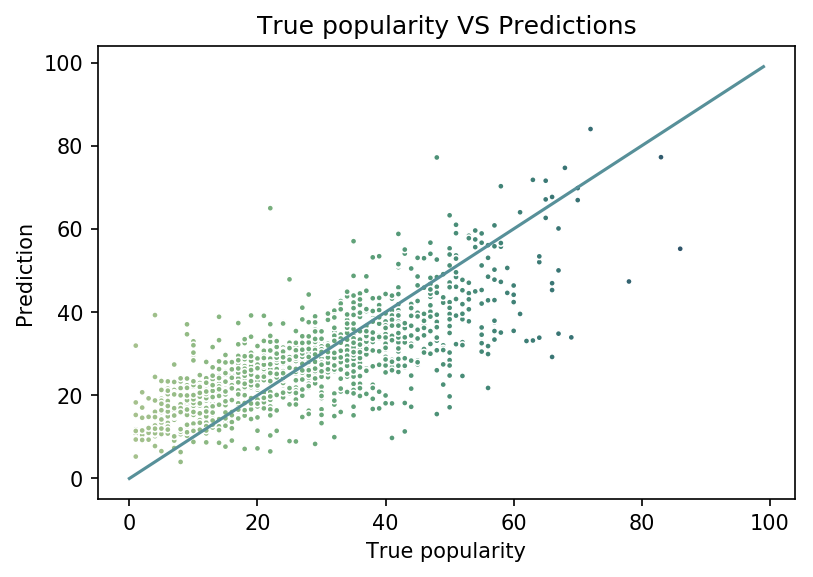

In [84]:
# Best Model
matchPlot = ridgePredictions.drop('features').toPandas()

# Define some colors
cmap = sns.cubehelix_palette(start=0.3, rot=-0.75,dark=.3, light=.7, as_cmap=True)
cmap1 = sns.cubehelix_palette(dark=.5, light=.5, as_cmap=True,rot=-0.2,start=-0.2)

# Plot a scatter plot popularity vs prediction
plt.figure(dpi=150)
sns.scatterplot(data=matchPlot, \
                x='label', \
                y='prediction', \
                marker='.', \
                hue='label', \
                palette=cmap, \
                legend=False) \
    .set_title("True popularity VS Predictions")

# Define some dataframe to be used to draw a line y=x
tt = np.arange(0,100,1)
zeros = np.zeros(100)
tt_df = pd.DataFrame([tt,tt,zeros])
tt_df = tt_df.transpose()
tt_df.columns = ['0','1','2']

# Plot the abline y=x for reference
sns.lineplot(data=tt_df, \
             x='0', \
             y='1', \
             dashes=True, \
             hue='2', \
             palette=cmap1, \
             legend=False)
plt.xlabel('True popularity')
plt.ylabel('Prediction')
plt.show()

## Important Result

In [102]:
# Ridge Regression Summary
ridge_result = {
    'variable':['intercept'] + featureCol,
    'coefficient':[ridgeBest.intercept] + list(ridgeBest.coefficients),
    'p-value':ridgeBest.summary.pValues
}
lr_summary = pd.DataFrame(ridge_result)
lr_summary.to_csv('lr_summary.csv', index=False)
lr_summary.head(10)

,variable,coefficient,p-value
0,intercept,30.495465,0.660482
1,album,-0.170478,0.024670
2,single,0.781784,0.003617
3,compilation,-0.780993,0.000000
4,is_explicit,1.389197,0.344711
5,danceability,0.184146,0.124678
6,energy,-0.407592,0.440596
7,C Key,0.171470,0.774786
8,C#/Db Key,0.061350,0.948257
9,D Key,-0.014127,0.157702


In [103]:
# Random Forest Feature Importance
rf_result = {
    'variable':featureCol,
    'coefficient':list(rfBest.featureImportances)
}
rf_feature_importance = pd.DataFrame(rf_result)
rf_feature_importance.to_csv('rf_feature_importance.csv', index=False)
rf_feature_importance.head(10)

,variable,coefficient
0,album,0.007017
1,single,0.016122
2,compilation,0.010399
3,is_explicit,0.021083
4,danceability,0.026057
5,energy,0.022834
6,C Key,0.002863
7,C#/Db Key,0.001444
8,D Key,0.001966
9,D#/Eb Key,0.000284
